In [37]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.pipeline import Pipeline
import seaborn as sns
from sklearn.base import BaseEstimator
from sklearn.compose import ColumnTransformer 
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
import featuretools.variable_types as vtypes
import seaborn as sns
from decimal import Decimal
from math import  modf
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from numpy import mean
#from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from imblearn.ensemble import EasyEnsembleClassifier
from sklearn.metrics import balanced_accuracy_score

#### Readin the data

In [106]:
#read csv file
df = pd.read_csv('train.csv', sep=';') 
dftest = pd.read_csv('test.csv', sep=';')


In [116]:
test_claim_id = dftest.claim_id.to_numpy() # saving the id so we can uploat to the leader board

#### Anomoulous values in claim_vehicle_load
The vehicule load is unlikely to be a number above 100. Only one observation had a value of 500. Therefore we replace all the values above 20 with missing.

In [3]:
df["claim_vehicle_load"].nlargest(5)

35617    500.00
20096      5.50
8673       5.49
13984      4.60
40231      4.60
Name: claim_vehicle_load, dtype: float64

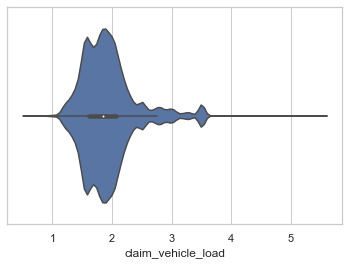

In [4]:
df.loc[(df.claim_vehicle_load > 20),'claim_vehicle_load']= np.nan
sns.set_theme(style="whitegrid")
ax = sns.violinplot(x=df["claim_vehicle_load"])

In [51]:
dftest["claim_vehicle_load"].nlargest(5) #no problems in the test data

18715    6.5
12078    4.6
31       3.5
92       3.5
367      3.5
Name: claim_vehicle_load, dtype: float64

**Create features about time (year, month, day, dayoftheweek)**

The following features contain a date and they should create additional features accordingly.

In [5]:
date_cols = [col for col in df.columns if 'date' in col]
print(date_cols)

['claim_date_registered', 'claim_date_occured', 'claim_vehicle_date_inuse', 'policy_date_start', 'policy_date_next_expiry', 'policy_date_last_renewed']


In [53]:
date_cols_dftest = [col for col in dftest.columns if 'date' in col]
print(date_cols_dftest)

['claim_date_registered', 'claim_date_occured', 'claim_vehicle_date_inuse', 'policy_date_start', 'policy_date_next_expiry', 'policy_date_last_renewed']


These features might contain date values out of bounds, so we replace those for missing and later change to date format.

In [6]:
top_date1=20300101
top_date2=203001
df.loc[(df.claim_date_registered > top_date1),'claim_date_registered']= np.nan
df.loc[(df.claim_date_occured > top_date1),'claim_date_occured']= np.nan
df.loc[(df.claim_vehicle_date_inuse > top_date2),'claim_vehicle_date_inuse']= np.nan
df.loc[(df.policy_date_start > top_date2),'policy_date_start']= np.nan
df.loc[(df.policy_date_next_expiry > top_date2),'policy_date_next_expiry']= np.nan
df.loc[(df.policy_date_last_renewed > top_date2),'policy_date_last_renewed']= np.nan

In [54]:
top_date1=20300101
top_date2=203001
dftest.loc[(dftest.claim_date_registered > top_date1),'claim_date_registered']= np.nan
dftest.loc[(dftest.claim_date_occured > top_date1),'claim_date_occured']= np.nan
dftest.loc[(dftest.claim_vehicle_date_inuse > top_date2),'claim_vehicle_date_inuse']= np.nan
dftest.loc[(dftest.policy_date_start > top_date2),'policy_date_start']= np.nan
dftest.loc[(dftest.policy_date_next_expiry > top_date2),'policy_date_next_expiry']= np.nan
dftest.loc[(dftest.policy_date_last_renewed > top_date2),'policy_date_last_renewed']= np.nan

We change their type to date time

In [7]:
df['claim_date_registered']=pd.to_datetime(df['claim_date_registered'].astype(str), format='%Y%m%d')
df['claim_date_occured']=pd.to_datetime(df['claim_date_occured'].astype(str), format='%Y%m%d')
df['claim_vehicle_date_inuse']=pd.to_datetime(df['claim_vehicle_date_inuse'].astype(str).str[:6], format='%Y%m')
df['policy_date_start']=pd.to_datetime(df['policy_date_start'].astype(str).str[:6], format='%Y%m')
df['policy_date_next_expiry']=pd.to_datetime(df['policy_date_next_expiry'].astype(str).str[:6], format='%Y%m')
df['policy_date_last_renewed']=pd.to_datetime(df['policy_date_last_renewed'].astype(str).str[:6], format='%Y%m')


In [55]:
dftest['claim_date_registered']=pd.to_datetime(dftest['claim_date_registered'].astype(str), format='%Y%m%d')
dftest['claim_date_occured']=pd.to_datetime(dftest['claim_date_occured'].astype(str), format='%Y%m%d')
dftest['claim_vehicle_date_inuse']=pd.to_datetime(dftest['claim_vehicle_date_inuse'].astype(str).str[:6], format='%Y%m')
dftest['policy_date_start']=pd.to_datetime(dftest['policy_date_start'].astype(str).str[:6], format='%Y%m')
dftest['policy_date_next_expiry']=pd.to_datetime(dftest['policy_date_next_expiry'].astype(str).str[:6], format='%Y%m')
dftest['policy_date_last_renewed']=pd.to_datetime(dftest['policy_date_last_renewed'].astype(str).str[:6], format='%Y%m')


Now we create variables related to year, month, day and day of week

In [ ]:
for col in date_cols[0:2]:
    dftest[col+'_dayweek']= df[col].dt.dayofweek
    df[col+'_year']= df[col].dt.year
    df[col+'_month']= df[col].dt.month
    df[col+'_day']= df[col].dt.day
for col in date_cols[2:]:
    df[col+'_year']= df[col].dt.year
    df[col+'_month']= df[col].dt.month

In [56]:
for col in date_cols_dftest[0:2]:
    dftest[col+'_dayweek']= dftest[col].dt.dayofweek
    dftest[col+'_year']= dftest[col].dt.year
    dftest[col+'_month']= dftest[col].dt.month
    dftest[col+'_day']= dftest[col].dt.day
for col in date_cols_dftest[2:]:
    dftest[col+'_year']= dftest[col].dt.year
    dftest[col+'_month']= dftest[col].dt.month

It is also important to have duration between claim_date_registered and claim_date_occured, also between claim_date_registered and policy_date_start

In [9]:
df['duration_claim_reg_occured']=(df['claim_date_registered']-df['claim_date_occured']).dt.total_seconds() / (24 * 60 * 60)
df['duration_claim_reg_policy_start']=(df['claim_date_registered']-df['policy_date_start']).dt.total_seconds() / (24 * 60 * 60)

In [57]:
dftest['duration_claim_reg_occured']=(dftest['claim_date_registered']-dftest['claim_date_occured']).dt.total_seconds() / (24 * 60 * 60)
dftest['duration_claim_reg_policy_start']=(dftest['claim_date_registered']-dftest['policy_date_start']).dt.total_seconds() / (24 * 60 * 60)

We drop the date variables so we can run the model

In [10]:
df.drop(date_cols, axis = 1, inplace = True)

In [ ]:
dftest.drop(date_cols, axis = 1, inplace = True)

**Adding columns to pinpoint missing values**

Later on the missing values will be imputed, but it is important to keep a record of the imputed values. Therefore we add a column for each feature.

In [11]:
for col in df.columns:
    df[col+'_miss'] = pd.isnull(df[col])*1
#list of added columns
miss_col = [col for col in df.columns if 'miss' in col]
miss_col.remove('fraud_miss') #don't keep the target
miss_col.remove('claim_amount_miss') #don't keep information you don't have at the start

In [60]:
for col in dftest.columns:
    dftest[col+'_miss'] = pd.isnull(dftest[col])*1
#list of added columns
miss_col_dftest = [col for col in dftest.columns if 'miss' in col]
miss_col_dftest.remove('fraud_miss') #don't keep the target
miss_col_dftest.remove('claim_amount_miss') #don't keep information you don't have at the start

ValueError: list.remove(x): x not in list

#### Label and categorize
We label the object type variables or categorize them to later on impute them


In [62]:
labelencoder = LabelEncoder()
df['fraud'] = labelencoder.fit_transform(df['fraud'])
df['claim_cause'] = labelencoder.fit_transform(df['claim_cause'])
df['claim_liable'] = labelencoder.fit_transform(df['claim_liable'])
df['claim_police'] = labelencoder.fit_transform(df['claim_police'])
df['claim_alcohol'] = labelencoder.fit_transform(df['claim_alcohol'])
df['claim_vehicle_id'] = labelencoder.fit_transform(df['claim_vehicle_id'])
df['claim_vehicle_brand'] = labelencoder.fit_transform(df['claim_vehicle_brand'])
#df['claim_vehicle_brand'] =df['claim_vehicle_brand'].astype(float)
#df['claim_vehicle_brand'] = df.claim_vehicle_brand.astype('category')
df["claim_vehicle_brand"] = df["claim_vehicle_brand"].astype('category')
df["claim_vehicle_brand"] = df["claim_vehicle_brand"].cat.codes.astype(float)
df['claim_vehicle_type'] = labelencoder.fit_transform(df['claim_vehicle_type'])
df['policy_holder_form'] = labelencoder.fit_transform(df['policy_holder_form'])
df["policy_holder_form"] = df["policy_holder_form"].astype('category')
df["policy_holder_form"] = df["policy_holder_form"].cat.codes.astype(float)
df['policy_holder_country'] = labelencoder.fit_transform(df['policy_holder_country'])
df["policy_holder_country"] = df["policy_holder_country"].astype('category')
df["policy_holder_country"] = df["policy_holder_country"].cat.codes.astype(float)
#df['driver_country'] = labelencoder.fit_transform(df['driver_country'])
df["driver_country"] = df["driver_country"].astype('category')
df["driver_country"] = df["driver_country"].cat.codes.astype(float)
df['driver_injured'] = labelencoder.fit_transform(df['driver_injured'])

#df['repair_form'] = labelencoder.fit_transform(df['repair_form'])
df["repair_form"] = df["repair_form"].astype('category')
df["repair_form"] = df["repair_form"].cat.codes.astype(float)

df['repair_country'] = labelencoder.fit_transform(df['repair_country'])
# df["repair_country"] = df["repair_country"].astype('category')
# df["repair_country"] = df["repair_country"].cat.codes.astype(float)
#df['repair_sla'] = labelencoder.fit_transform(df['repair_sla'])
df["repair_sla"] = df["repair_sla"].astype('category')
df["repair_sla"] = df["repair_sla"].cat.codes.astype(float)



In [64]:
labelencoder = LabelEncoder()
#dftest['fraud'] = labelencoder.fit_transform(dftest['fraud'])
dftest['claim_cause'] = labelencoder.fit_transform(dftest['claim_cause'])
dftest['claim_liable'] = labelencoder.fit_transform(dftest['claim_liable'])
dftest['claim_police'] = labelencoder.fit_transform(dftest['claim_police'])
dftest['claim_alcohol'] = labelencoder.fit_transform(dftest['claim_alcohol'])
dftest['claim_vehicle_id'] = labelencoder.fit_transform(dftest['claim_vehicle_id'])
dftest['claim_vehicle_brand'] = labelencoder.fit_transform(dftest['claim_vehicle_brand'])
#dftest['claim_vehicle_brand'] =dftest['claim_vehicle_brand'].astype(float)
#dftest['claim_vehicle_brand'] = df.claim_vehicle_brand.astype('category')
dftest["claim_vehicle_brand"] = dftest["claim_vehicle_brand"].astype('category')
dftest["claim_vehicle_brand"] = dftest["claim_vehicle_brand"].cat.codes.astype(float)
dftest['claim_vehicle_type'] = labelencoder.fit_transform(dftest['claim_vehicle_type'])
dftest['policy_holder_form'] = labelencoder.fit_transform(dftest['policy_holder_form'])
dftest["policy_holder_form"] = dftest["policy_holder_form"].astype('category')
dftest["policy_holder_form"] = dftest["policy_holder_form"].cat.codes.astype(float)
dftest['policy_holder_country'] = labelencoder.fit_transform(dftest['policy_holder_country'])
dftest["policy_holder_country"] = dftest["policy_holder_country"].astype('category')
dftest["policy_holder_country"] = dftest["policy_holder_country"].cat.codes.astype(float)
#dftest['driver_country'] = labelencoder.fit_transform(dftest['driver_country'])
dftest["driver_country"] = dftest["driver_country"].astype('category')
dftest["driver_country"] = dftest["driver_country"].cat.codes.astype(float)
dftest['driver_injured'] = labelencoder.fit_transform(dftest['driver_injured'])

#dftest['repair_form'] = labelencoder.fit_transform(dftest['repair_form'])
dftest["repair_form"] = dftest["repair_form"].astype('category')
dftest["repair_form"] = dftest["repair_form"].cat.codes.astype(float)

dftest['repair_country'] = labelencoder.fit_transform(dftest['repair_country'])


#### Separate target and source variables
We drop the the claim_amount from the source variables because it is not information assumed to be available at the start of the claim procedure. Also, the year of the claim must be dropped becasue it is a constant.The separation between train and validation data is a 80/20 percent split.

In [13]:
# Separate target and source variables

y = df.fraud
X = df.drop(['fraud','claim_amount','fraud_miss','claim_amount_miss', 'claim_date_registered_year', ], axis=1)
# The 20 % of data is test size of the data 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, stratify=y)

## Sklearn pipeline
We first list the variables according to the strategy for imputation and creation of dummies

In [14]:
median_feats = ['policy_coverage_1000','policy_premium_100','claim_vehicle_load','claim_vehicle_cyl','claim_time_occured','claim_num_injured','claim_num_third_parties','claim_num_vehicles']
most_freq_feats = ['claim_date_registered_month',
                     'claim_date_registered_day',
                     'claim_date_occured_dayweek',
                     'claim_date_occured_year',
                     'claim_date_occured_month',
                     'claim_date_occured_day',
                     'claim_vehicle_date_inuse_year',
                     'claim_vehicle_date_inuse_month',
                     'policy_date_start_year',
                     'policy_date_start_month',
                     'policy_date_next_expiry_year',
                     'policy_date_next_expiry_month',
                     'policy_date_last_renewed_year',
                     'policy_date_last_renewed_month',
                     'duration_claim_reg_occured',
                     'duration_claim_reg_policy_start',
                   'claim_date_registered_dayweek','policy_num_changes','policy_num_changes','repair_sla','repair_country','repair_year_birth','repair_form','repair_postal_code','driver_injured','driver_country','driver_year_birth','policy_holder_country','policy_holder_year_birth','policy_holder_form','policy_holder_postal_code','claim_vehicle_power','claim_vehicle_fuel_type','claim_vehicle_type','claim_vehicle_brand','claim_vehicle_id','claim_language','claim_alcohol','claim_police','claim_liable','claim_postal_code','claim_cause','claim_postal_code']
most_freq_feats = most_freq_feats+miss_col
hot_feats = ['claim_vehicle_brand','repair_form']


We create the pre_process step

In [15]:
pre_process = ColumnTransformer(remainder='drop', transformers=[
                                ('impute_median', SimpleImputer(strategy='median'), median_feats),
                                ('impute_most_freq', SimpleImputer(strategy='most_frequent'), most_freq_feats),
                                ('one_hot',OneHotEncoder(),hot_feats)])
#('one_hot',OneHotEncoder(),hot_feats)

The object model_pipeline has two steps: pre_processing and the model

In [16]:
model_pipeline = Pipeline(steps=[('pre_processing',pre_process),
                                 ('random_forest', RandomForestClassifier(random_state=0))
                                 ])

We train the model and, as expected, a Random Forest cannot deal with severily imbalanced data. The model overfits.

In [17]:
#y_train=y_train.astype(float)
m1 = model_pipeline.fit(X_train,y_train)

In [18]:
# MSE = []
# MSE.append(mean_squared_error(y_train,model_pipeline.predict(X_train))**0.5)
# MSE

# y_prediction =model_pipeline.predict(X_train)
# accuracy_score(y_train, y_prediction)
y_prediction =model_pipeline.predict(X_train)
print(accuracy_score(y_train, y_prediction))
confusion_matrix(y_train, y_prediction)

0.9999549244985351


array([[44124,     0],
       [    2,   244]], dtype=int64)

In [19]:
y_prediction_test =model_pipeline.predict(X_test)
print(accuracy_score(y_test, y_prediction_test))
confusion_matrix(y_test, y_prediction_test)

0.9943207428107815


array([[11030,     1],
       [   62,     0]], dtype=int64)

We create another pipeline to transform the data and later use it in different models.

In [20]:
pre1_process = ColumnTransformer(remainder='drop', transformers=[
                                ('impute_median', SimpleImputer(strategy='median'), median_feats),
                                ('impute_most_freq', SimpleImputer(strategy='most_frequent'), most_freq_feats),
                                ('one_hot',OneHotEncoder(),hot_feats)])
#('one_hot',OneHotEncoder(),hot_feats)
prepro_pipeline = Pipeline(steps=[('pre_processing',pre1_process)])

We transform the features.

In [66]:
train_prepared = prepro_pipeline.fit_transform(X_train)
test_prepared = prepro_pipeline.fit_transform(X_test)
dftest_prepared = prepro_pipeline.fit_transform(dftest)

### Grid search for Random Forest

In [22]:
rfc=RandomForestClassifier(random_state=0)

In [23]:
 param_grid = [
        {'max_depth': [10, 20, 30,50,70,80],
         'min_samples_leaf': [1, 2, 4]
        },
    ]

In [24]:
grid_search = GridSearchCV(rfc, param_grid, cv=5,scoring='accuracy', refit=True)


In [25]:
grid_search.fit(train_prepared, y_train)


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=0),
             param_grid=[{'max_depth': [10, 20, 30, 50, 70, 80],
                          'min_samples_leaf': [1, 2, 4]}],
             scoring='accuracy')

In [26]:
print('Final score is: ', grid_search.score(test_prepared, y_test))

Final score is:  0.994410889750293


In [27]:
final_model = grid_search.best_estimator_

In [28]:
final_predictions = final_model.predict(test_prepared)

Even after grid search the model still overfits

In [29]:
confusion_matrix(y_test, final_predictions)

array([[11031,     0],
       [   62,     0]], dtype=int64)

### Easy ensemble

In [34]:
# define model
easy_model = EasyEnsembleClassifier(n_estimators=10)
# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=0)
# evaluate model
scores = cross_val_score(easy_model, train_prepared, y_train, scoring='roc_auc', cv=cv, n_jobs=-1)
# summarize performance
print('Mean ROC AUC: %.3f' % mean(scores))

Mean ROC AUC: 0.851


In [38]:
eec = EasyEnsembleClassifier(random_state=0)
eec.fit(train_prepared, y_train) 
y_pred_eec = eec.predict(test_prepared)
balanced_accuracy_score(y_test, y_pred_eec)  

0.7940788569456751

In [39]:
confusion_matrix(y_test, y_pred_eec)

array([[8623, 2408],
       [  12,   50]], dtype=int64)

### Make predictions
Using the ensemble model and then create a csv file to upload to the board

In [100]:
# Strangely one column is not int
dftest_prepared[:,27] = (np.where(dftest_prepared[:,27]=='Y', 1, dftest_prepared[:,27]))
dftest_prepared[:,27] = (np.where(dftest_prepared[:,27]=='N', 0, dftest_prepared[:,27]))
print(dftest_prepared[:,27])

In [ ]:
y_pred_eec_upload = eec.predict_proba(dftest_prepared)

In [121]:
y_pred_eec_0_1 = eec.predict(dftest_prepared)

In [128]:
dfleader = pd.DataFrame({'ID':test_claim_id, 'PROB':y_pred_eec_upload[:,1]})
dfleader.to_csv('dfleader.csv',index=False)

We recoverd 67431.33 and have AUC equal to 0.81026228, position 33